In [22]:
from IPython.display import display, Math
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

### Define function

In [23]:
def show_matrix(A):
    plt.imshow(np.abs(A))
    plt.colorbar()
    plt.title(r"$|\mathcal{T}_{\text{choi}}|$")
    plt.show()

In [24]:
def complex_ndarray_to_latex_polar(A, precision=3, tol=1e-12):
    rows = []
    for row in A:
        entries = []
        for z in row:
            r = np.abs(z)
            theta = np.angle(z)

            if r < tol:
                entries.append("0")
            elif abs(theta) < tol:
                entries.append(f"{r:.{precision}f}")
            else:
                entries.append(
                    f"{r:.{precision}f} e^{{{theta:.{precision}f}\\,\\mathrm{{i}}}}"
                )
        rows.append(" & ".join(entries))

    body = r" \\ ".join(rows)
    return r"\begin{pmatrix}" + body + r"\end{pmatrix}"

In [25]:
def apply_channel_from_choi(A, x):
    d_in = x.shape[0]
    d_out = A.shape[0] // d_in

    IxT = np.kron(np.eye(d_out), x.T)
    M = IxT @ A

    M = M.reshape(d_out, d_in, d_out, d_in)

    y = np.einsum('a i b i -> a b', M)

    return y

In [26]:
def copy_maker(x, n_copies):
    result = x
    for _ in range(n_copies - 1):
        result = np.kron(result, x)
    return result


def fidelity(x, y):
    sqrt_x = sqrtm(x)
    m = sqrt_x @ y @ sqrt_x

    sqrt_m = sqrtm(m)
    F = np.real(np.trace(sqrt_m))**2

    return F

In [27]:
def pure_state_maker(d, k):
    x = np.zeros((d, d), dtype=complex)
    x[k, k] = 1.0
    return x

def maximally_mixed_state_maker(d):
    x = np.eye(d, dtype=complex)
    x /= d
    return x

def random_mixed_state_maker(d):
    A = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    rho = A @ A.conj().T
    rho /= np.trace(rho)
    
    return rho

In [37]:
import os 
import ast

def load_choi_blocks(filename: str) -> dict:
    if not os.path.exists(filename):
        raise FileNotFoundError(f"파일 없음: {filename}")

    blocks = {}
    with np.load(filename, allow_pickle=True) as data:
        for k in data.files:
            try:
                # ast.literal_eval을 사용하여 "(5, 2)" -> (5, 2) 복원
                key_tuple = ast.literal_eval(k)
                blocks[key_tuple] = data[k].copy()
            except (ValueError, SyntaxError):
                # 변환 불가능한 키는 스킵
                continue
    return blocks

In [63]:
from utils import *

def rho_blocks(n: int, p: float, j2_list):
        return {j2: rho_block_diag_in_spin_irrep(n, j2, p) for j2 in j2_list}
    
def apply_channel_blocks_numpy(J_blocks, p: float, n_in: int, n_out: int):
    j2_in_list = j2_list_for_n_qubits(n_in)
    j2_out_list = j2_list_for_n_qubits(n_out)
    rho_in = rho_blocks(n_in, float(p), j2_in_list)
    mult_in = {j2: mult_qubits(n_in, j2) for j2 in j2_in_list}
    sigma = {}
    for j2o in j2_out_list:
        d_out = j2o + 1
        sig = np.zeros((d_out, d_out), dtype=complex)
        for j2i in j2_in_list:
            d_in = j2i + 1
            J = J_blocks[(j2o, j2i)]
            K = np.kron(np.eye(d_out, dtype=complex), rho_in[j2i].T)
            M = K @ J
            sig_part = partial_trace_numpy(M, d_out, d_in, axis=1)
            sig += mult_in[j2i] * sig_part
        sigma[j2o] = (sig + sig.conj().T) / 2
    return sigma

def fidelity_block(p: float, sigma_blocks, n_out):
    j2_out_list = j2_list_for_n_qubits(n_out)
    alpha = rho_blocks(n_out, float(p), j2_out_list)
    f = 0.0
    for j2o in j2_out_list:
        f_j = fidelity_root_numpy(alpha[j2o], sigma_blocks[j2o])
        f += mult_qubits(n_out, j2o) * f_j
    return float(f) ** 2

### Load choi operator

In [64]:
# change this parameter!!!

d = 2

method = "sdp_perm"  # "sdp_fix", "sdp", "sdp_perm_fix", "sdp_perm"
n_in = 2
n_out = 10

if method in ["sdp", "sdp_fix"]:
    A = np.load(f"data/{method}/{n_in}_to_{n_out}.npy")
else:
    A = load_choi_blocks(f"data/{method}/{n_in}_to_{n_out}.npz")

In [65]:
# show_matrix(A)

In [66]:
if method in ["sdp", "sdp_fix"]:
    x_min = pure_state_maker(d) 
    y_min = apply_channel_from_choi(A, copy_maker(x_min, n_in))

    latex_str = complex_ndarray_to_latex_polar(y_min)
    display(Math(r"y = " + latex_str))
    f_pure = fidelity(copy_maker(x_min, n_out), y_min)
    
    x_max = maximally_mixed_state_maker(d) 
    y_max = apply_channel_from_choi(A, copy_maker(x_max, n_in))

    latex_str = complex_ndarray_to_latex_polar(y_max)
    display(Math(r"y = " + latex_str))
    f_mixed = fidelity(copy_maker(x_max, n_out), y_max)
else:
    sigma_blocks = apply_channel_blocks_numpy(A, float(1.0), n_in=n_in, n_out=n_out)
    f_pure = fidelity_block(float(1.0), sigma_blocks, n_out=n_out)
    sigma_blocks = apply_channel_blocks_numpy(A, float(0.5), n_in=n_in, n_out=n_out)
    f_mixed = fidelity_block(float(0.5), sigma_blocks, n_out=n_out)
        

print("Pure state fidelity: ", f_pure)
print("Maximally mixed state fidelity: ", f_mixed)

Pure state fidelity:  0.267469724054228
Maximally mixed state fidelity:  0.3273569515306642


In [67]:
if method in ["sdp", "sdp_fix"]:
    x_rand = random_mixed_state_maker(d) 
    y_rand = apply_channel_from_choi(A, copy_maker(x_rand, n_in))

    latex_str_x = complex_ndarray_to_latex_polar(copy_maker(x_rand, n_out))
    latex_str_y = complex_ndarray_to_latex_polar(y_rand)
    f_rnd = fidelity(copy_maker(x_rand, n_out), y_rand)
else:
    p = np.random.uniform(0.5, 1.0)
    sigma_blocks = apply_channel_blocks_numpy(A, float(p), n_in=n_in, n_out=n_out)
    f_rnd = fidelity_block(float(p), sigma_blocks, n_out=n_out)
print("Random mixed state fidelity: ", f_rnd)

Random mixed state fidelity:  0.3166908489905228


[1/25] p = 0.500, Fidelity = 0.327357
[2/25] p = 0.521, Fidelity = 0.326800
[3/25] p = 0.542, Fidelity = 0.325146
[4/25] p = 0.562, Fidelity = 0.322451
[5/25] p = 0.583, Fidelity = 0.318803
[6/25] p = 0.604, Fidelity = 0.314325
[7/25] p = 0.625, Fidelity = 0.309167
[8/25] p = 0.646, Fidelity = 0.303509
[9/25] p = 0.667, Fidelity = 0.297551
[10/25] p = 0.688, Fidelity = 0.291514
[11/25] p = 0.708, Fidelity = 0.285635
[12/25] p = 0.729, Fidelity = 0.280160
[13/25] p = 0.750, Fidelity = 0.275348
[14/25] p = 0.771, Fidelity = 0.271463
[15/25] p = 0.792, Fidelity = 0.268775
[16/25] p = 0.812, Fidelity = 0.267556
[17/25] p = 0.833, Fidelity = 0.268073
[18/25] p = 0.854, Fidelity = 0.270585
[19/25] p = 0.875, Fidelity = 0.275313
[20/25] p = 0.896, Fidelity = 0.282400
[21/25] p = 0.917, Fidelity = 0.291799
[22/25] p = 0.938, Fidelity = 0.303025
[23/25] p = 0.958, Fidelity = 0.314476
[24/25] p = 0.979, Fidelity = 0.320910
[25/25] p = 1.000, Fidelity = 0.267470


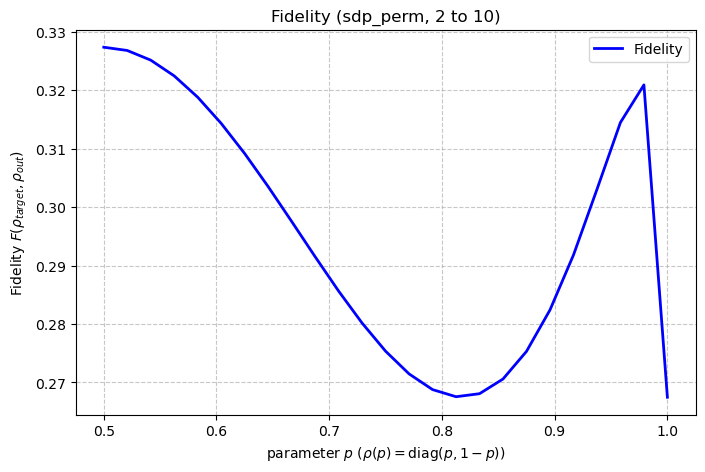

In [68]:
import numpy as np
import matplotlib.pyplot as plt


def generate_diagonal_rho(p, d):
    """
    p: 첫 번째 대각 성분의 확률 값 (0.5 <= p <= 1.0)
    d: Hilbert 공간의 차원
    """
    rho = np.zeros((d, d), dtype=complex)
    rho[0, 0] = p
    if d > 1:
        # 나머지 성분들에 대해 (1-p)를 균등 배분 (Tr(rho) = 1 유지)
        remaining_val = (1 - p) / (d - 1)
        for i in range(1, d):
            rho[i, i] = remaining_val
    return rho

# 실험 설정
n_grid = 25
p_values = np.linspace(0.5, 1.0, n_grid)
fidelities = []

# 기존에 정의된 d, A, n_in, n_out 변수가 존재한다고 가정함
for i, p in enumerate(p_values):
    if method in ["sdp", "sdp_fix"]:
        # 1. 대각 입력 상태 rho 생성
        rho_p = generate_diagonal_rho(p, d)
        
        # 2. 채널 적용: y = Phi(rho^{\otimes n_in})
        # 사용자의 코드 구조에 따라 copy_maker를 적용
        x_input = copy_maker(rho_p, n_in)
        y_out = apply_channel_from_choi(A, x_input)
        
        # 3. 기준 상태(Target) 생성 및 Fidelity 계산
        # 사용자의 snippet 기준: copy_maker(rho_p, n_out)와 비교
        target_state = copy_maker(rho_p, n_out)
        f = fidelity(target_state, y_out)
    
    else:
        sigma_blocks = apply_channel_blocks_numpy(A, float(p), n_in=n_in, n_out=n_out)
        f = fidelity_block(float(p), sigma_blocks, n_out=n_out)
    
    fidelities.append(f)
    
    print(f"[{i+1}/{n_grid}] p = {p:.3f}, Fidelity = {f:.6f}")

# 그래프 출력
plt.figure(figsize=(8, 5))
plt.plot(p_values, fidelities, label='Fidelity', color='blue', linewidth=2)
plt.xlabel(r'parameter $p$ ($\rho(p) = \mathrm{diag}(p, 1-p)$)')
plt.ylabel(r'Fidelity $F(\rho_{target}, \rho_{out})$')
plt.title(f'Fidelity ({method}, {n_in} to {n_out})')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# plt.savefig(f"figure/fidelity_{method}_{n_in}_to_{n_out}.png")
plt.show()